In [ ]:
#| default_exp 07-metadata-augmented-input-and-trie-for-distilbert-with-thresholding

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, pandas as pd, warnings, torch, pickle, numpy as np
from tqdm.auto import tqdm
from scipy import stats

import xclib.utils.sparse as xs

from xcai.basics import *
from xcai.models.MMM00X import DBT007, DBT008
from xcai.transform import AugmentMetaInputIdsTfm

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
dump_dir = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/07-metadata-augmented-input-and-trie-for-distilbert-with-thresholding/'

In [ ]:
#| export
fname = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/data/block.pkl'
with open(fname, 'rb') as f: block, test_dset = pickle.load(f)

# Generation

In [ ]:
#| export
mname = f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0)

Some weights of DBT007 were not initialized from the model checkpoint at /scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000 and are newly initialized: ['loss_fn.o']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
args = XCLearningArguments(
    output_dir=f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K',
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
#| export
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## `meta-augmented trie`

In [ ]:
lbl_toks = block.lbl_info['input_ids']
lbl_info = [[i] for i in range(len(lbl_toks))]

trie = Trie.from_list(lbl_toks, lbl_info)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [ ]:
meta_lbl = block.train.dset.meta.hlk_meta.lbl_meta.T.tocsr()

In [ ]:
n_lbl = meta_lbl.getnnz(axis=1)
valid_meta_idx = np.where(np.logical_and(n_lbl>1, n_lbl<100))[0]

In [ ]:
meta_toks = [block.train.dset.meta.hlk_meta.meta_info['input_ids'][i] for i in tqdm(valid_meta_idx)]
meta_info = [meta_lbl[i].indices.tolist() for i in tqdm(valid_meta_idx)]

  0%|          | 0/1174296 [00:00<?, ?it/s]

  0%|          | 0/1174296 [00:00<?, ?it/s]

In [ ]:
trie.update(meta_toks, meta_info)

  0%|          | 0/1174296 [00:00<?, ?it/s]

In [ ]:
#| export
learn.tbs.trie = trie

In [ ]:
learn.tbs.n_bm = learn.args.generation_num_beams = 50

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,15.35,8.3833,6.01,3.58,15.35,14.0982,14.327,15.0209,9.0689,8.3428,8.7275,9.5123,9.0689,9.154,9.6349,10.3323,11.1848,13.0305,16.894,23.3738,27.9886,34.5702,7.0555,1000.9102,1.998,0.063


In [ ]:
pred_fname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/predictions/test_lbl_atrie-hlk_n-bm-20_n-smp-2000_seed-50.pth'
os.makedirs(os.path.dirname(pred_fname), exist_ok=True)
torch.save(o, pred_fname)

### __Shortlist & Total recall__

All the numbers reported below are on a sample of 2000 points.

In [ ]:
s = get_tensor_statistics(o.pred_ptr);s

,mean,std,25,50,75
0,344.292511,190.243073,225.0,323.0,444.0


In [ ]:
r, rm = total_recall(o.pred_idx, o.pred_ptr, test_dset.data.data_lbl, test_dset.data.data_lbl_filterer) 
print(f'Total recall : {r*100:.3f}')

Total recall : 46.778


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
r = get_tensor_statistics(torch.tensor(rm.sum(axis=1)).flatten()*rm.shape[0]*100); r

,mean,std,25,50,75
0,46.778297,42.45533,0.0,50.0,100.0


In [ ]:
data_rec = torch.tensor(rm.sum(axis=1)).flatten()

<matplotlib.collections.PathCollection>

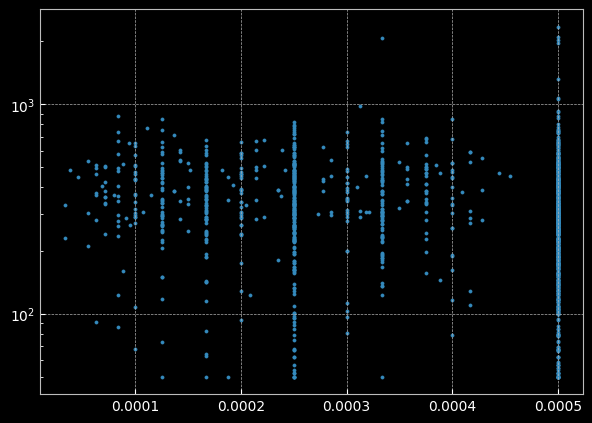

In [ ]:
import matplotlib.pyplot as plt

set_plot_defaults()
plt.figure(figsize=(7,5))
plt.yscale('log')
idx = torch.where(data_rec > 0)[0]
plt.scatter(data_rec[idx], o.pred_ptr[idx], s=5)

In [ ]:
stats.pearsonr(data_rec, o.pred_ptr), stats.spearmanr(data_rec, o.pred_ptr)

(PearsonRResult(statistic=-0.07536473441219829, pvalue=0.0007432584497593396),
 SignificanceResult(statistic=-0.1300839934767818, pvalue=5.260320390198579e-09))

# Representation

In [ ]:
args = XCLearningArguments(
    output_dir=f'{dump_dir}/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/',
    index_efs=200,
    representation_num_beams=200,
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()
model = DBT008.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', bsz=bsz, tn_targ=10_000, ig_tok=0)

Some weights of DBT008 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['loss_fn.u', 'loss_fn.v']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import OrderedDict

mname = f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/model_network.pkl'
m_state_dict, msd = OrderedDict(), torch.load(mname)
for k in msd:
    o = k.split('.')
    if o[0] == 'encoder': m_state_dict['distilbert.'+'.'.join(o[5:])] = msd[k]
model.load_state_dict(m_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['loss_fn.u', 'loss_fn.v'], unexpected_keys=[])

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Reranking

In [ ]:
import torch.nn.functional as F

In [ ]:
data_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset)), dim=1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
lbl_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset.lbl_dset)), dim=1)

  0%|          | 0/9761 [00:00<?, ?it/s]

In [ ]:
pred = torch.load(f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/\
predictions/test_lbl_atrie-hlk_n-bm-20_n-smp-2000_seed-50.pth')

In [ ]:
from tqdm.auto import tqdm
sc,p = [],0
for q,d in tqdm(zip(pred.pred_ptr.cumsum(0),data_repr), total=data_repr.shape[0]):
    sc.append(d@lbl_repr[pred.pred_idx[p:q]].T);p=q
sc = torch.cat(sc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
o = {
    'pred_idx': pred.pred_idx,
    'pred_ptr': pred.pred_ptr,
    'pred_score': pred.pred_score,
}
o['targ_idx'] = torch.tensor(test_dset.data.data_lbl.indices, dtype=torch.long)
o['targ_ptr'] = torch.tensor([o.getnnz() for o in test_dset.data.data_lbl])

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,15.35,8.383333,6.01,3.58,15.35,14.098239,14.327021,15.020876,9.068933,8.342776,8.727474,9.512342,9.068933,9.154033,9.634885,10.332335,11.184845,13.030487,16.894031,23.373788,27.988618,34.570228


In [ ]:
o['pred_score'] = sc

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,24.5,17.666667,13.58,8.855,24.5,25.789425,26.945745,29.209173,14.976389,18.060414,20.306584,24.901051,14.976388,17.913218,19.575518,21.996141,19.536944,24.318514,35.755559,44.097798,45.737241,46.459775
